In [1]:
from shapely.geometry import Point
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster

In [2]:
# pip install openpyxl

In [3]:
nswmap = pd.read_excel('../data/nsw-site-location-and-details.xlsx')
print(nswmap.shape)
nswmap.head(3)

(2255, 12)


,Site,Site_distance,Community,Latitude,Longitude,Easting,Northing,Zone,Datum,Location name,Tenure,Date sampled
0,CYP_001,CYP_001_000,Cypress pine,-32.314901,145.820500,6424048,388969,55,MGA94,Bedooba State Conservation Area,National Park,2013-09-11
1,CYP_001,CYP_001_050,Cypress pine,-32.314476,145.820346,6424095,388954,55,MGA94,Bedooba State Conservation Area,National Park,2013-09-11
2,CYP_001,CYP_001_100,Cypress pine,-32.314051,145.820182,6424142,388938,55,MGA94,Bedooba State Conservation Area,National Park,2013-09-11


In [4]:
dung = pd.read_excel('../data/nsw-assessment-of-grazing-intensity.xlsx', sheet_name='animal_dung')
print(dung.shape)
dung.head(3)

(6019, 7)


,Community,Site,Site.1,Scale,Animal,Attribute,Counts
0,Black box,BLA_001_000,BLA_001,0.25,Kangaroo,dung,1
1,Black box,BLA_001_000,BLA_001,25.00,Cow,dung,28
2,Black box,BLA_001_000,BLA_001,25.00,Kangaroo,dung,10


In [5]:
dungmap = pd.merge(left=dung,
                   right=nswmap[['Community', 'Latitude', 'Longitude', 'Location name']], 
                   how='left',
                   on='Site')

dungmap.head()

,Community,Site,Site.1,Scale,Animal,Attribute,Counts,Latitude,Longitude,Location name
0,Black box,BLA_001_000,BLA_001,0.25,Kangaroo,dung,1,-34.711825,146.211807,Benandra
1,Black box,BLA_001_000,BLA_001,0.25,Kangaroo,dung,1,-34.711436,146.211581,Benandra
2,Black box,BLA_001_000,BLA_001,0.25,Kangaroo,dung,1,-34.711011,146.211443,Benandra
3,Black box,BLA_001_000,BLA_001,0.25,Kangaroo,dung,1,-34.710595,146.211250,Benandra
4,Black box,BLA_001_000,BLA_001,0.25,Kangaroo,dung,1,-34.710161,146.211091,Benandra


In [6]:
# dung1 = dung[dung['Attribute'].notna()]

# # keep only dung counts
# dung1 = dung[dung['Attribute'].str.contains('dung')]

# dung1.head()

In [7]:
dungmap.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4527395 entries, 0 to 4527394
Data columns (total 10 columns):
 #   Column         Dtype  
---  ------         -----  
 0   Community      object 
 1   Site           object 
 2   Site.1         object 
 3   Scale          float64
 4   Animal         object 
 5   Attribute      object 
 6   Counts         int64  
 7   Latitude       float64
 8   Longitude      float64
 9   Location name  object 
dtypes: float64(3), int64(1), object(6)
memory usage: 345.4+ MB


In [8]:
dungmap['geometry'] = dungmap.apply(lambda x: Point((x.Longitude, 
                                                         x.Latitude)), 
                                        axis=1)
dungmap.head(3)

,Community,Site,Site.1,Scale,Animal,Attribute,Counts,Latitude,Longitude,Location name,geometry
0,Black box,BLA_001_000,BLA_001,0.25,Kangaroo,dung,1,-34.711825,146.211807,Benandra,POINT (146.211806657459 -34.711824788022)
1,Black box,BLA_001_000,BLA_001,0.25,Kangaroo,dung,1,-34.711436,146.211581,Benandra,POINT (146.211581027011 -34.7114355727612)
2,Black box,BLA_001_000,BLA_001,0.25,Kangaroo,dung,1,-34.711011,146.211443,Benandra,POINT (146.211443096319 -34.7110108544367)


In [9]:
dungmap = gpd.GeoDataFrame(dungmap, 
                           crs = 'EPSG:4326', 
                           geometry = dungmap['geometry'])

In [10]:
dungmap.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [11]:
type(dungmap)

geopandas.geodataframe.GeoDataFrame

<Axes: >

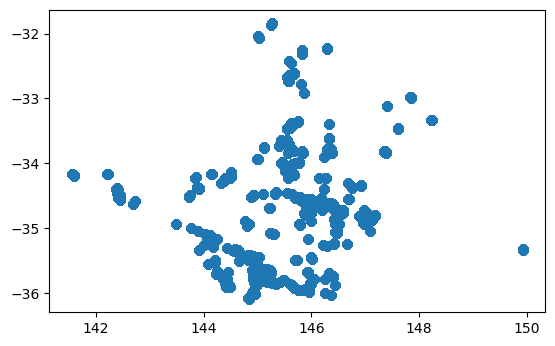

In [12]:
dungmap.plot()

<Axes: >

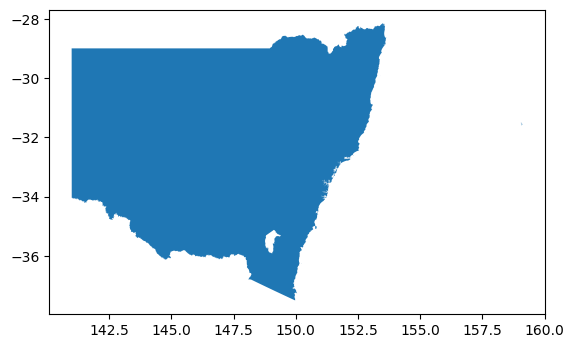

In [13]:
geodata = gpd.read_file('../data/STE_2021_AUST_GDA2020.shp')
nsw = geodata[geodata['STE_NAME21']== 'New South Wales']
nsw.plot()

In [14]:
nsw.crs = dungmap.crs

In [15]:
nsw.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<Axes: >

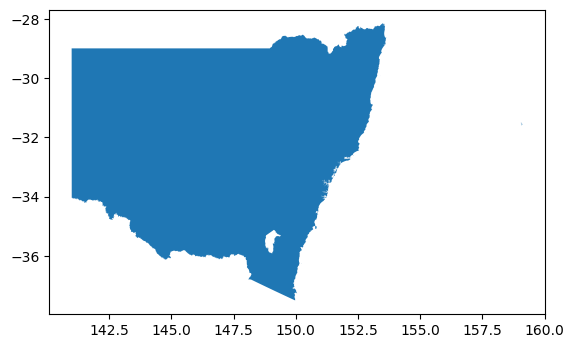

In [16]:
nsw.plot()

In [17]:
dungmap.head()

,Community,Site,Site.1,Scale,Animal,Attribute,Counts,Latitude,Longitude,Location name,geometry
0,Black box,BLA_001_000,BLA_001,0.25,Kangaroo,dung,1,-34.711825,146.211807,Benandra,POINT (146.21181 -34.71182)
1,Black box,BLA_001_000,BLA_001,0.25,Kangaroo,dung,1,-34.711436,146.211581,Benandra,POINT (146.21158 -34.71144)
2,Black box,BLA_001_000,BLA_001,0.25,Kangaroo,dung,1,-34.711011,146.211443,Benandra,POINT (146.21144 -34.71101)
3,Black box,BLA_001_000,BLA_001,0.25,Kangaroo,dung,1,-34.710595,146.211250,Benandra,POINT (146.21125 -34.71059)
4,Black box,BLA_001_000,BLA_001,0.25,Kangaroo,dung,1,-34.710161,146.211091,Benandra,POINT (146.21109 -34.71016)


In [18]:
type(nsw)

geopandas.geodataframe.GeoDataFrame

In [19]:
nsw_map = gpd.sjoin(nsw, dungmap, predicate = 'within')

In [20]:
border = nsw.loc[nsw['STE_NAME21'] == 'New South Wales']
border.shape

(1, 9)

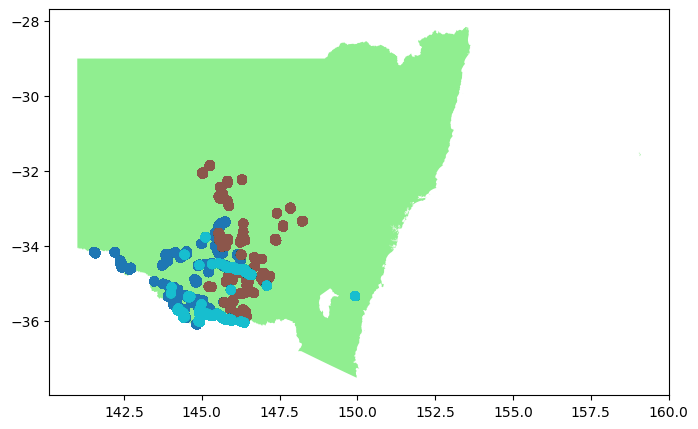

In [21]:
ax = border.plot(figsize = (8, 10), color = 'lightgreen')
dungmap.plot( ax = ax, column = 'Community');
plt.show();

In [22]:
border.geometry.centroid

C:\Users\HP\AppData\Local\Temp\ipykernel_12576\1165773.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  border.geometry.centroid


0    POINT (147.00820 -32.16562)
dtype: geometry

In [23]:
center = border.geometry.centroid[0]

C:\Users\HP\AppData\Local\Temp\ipykernel_12576\4157547962.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center = border.geometry.centroid[0]


In [24]:
print(center)

POINT (147.00819583947575 -32.16561978542047)


## Folium requires a location point as an array with latitude first
but shapely Points have longitude first

In [25]:
center.y

-32.16561978542047

In [26]:
# reverse the order when constructing the array for folium location
area_center = [center.y, center.x]

# check the order of area_center, the location for our folium map
print(area_center)

[-32.16561978542047, 147.00819583947575]


To create a folium map just call the folium Map() constructor
location is the only argument required by the constructor
Set area_center as the location of the folium map.
zoom_start is an optional argument
A setting of 12 should get us nice and close

In [27]:
#create our map of NSW and show it
map_nsw = folium.Map(location =  area_center, zoom_start = 10)
map_nsw

#### Next, let's add our dung points


In [ ]:
dungmap.head(1)

In [ ]:
#draw our zip code area: 37207
map_nsw = folium.Map(location =  area_center, zoom_start = 12)

folium.GeoJson(border).add_to(map_nsw)

#iterate through stops_in_37207 to create locations and markers 
#for each bus stop
#remember for Folium locations, lat is listed first!!

for row_index, row_values in dungmap.iterrows():
    loc = [row_values['Latitude'], row_values['Longitude']]
    pop = str(row_values['Animal', 'Attribute', 'Counts'])
    icon=folium.Icon(color="blue",icon="poo", prefix='fa')
    
    marker = folium.Marker(
        location = loc, 
        popup = pop, 
        icon = icon) 

    marker.add_to(map_nsw)
# map_37207.save('../maps/map37207.html')

#display our map
map_nsw